# Building Concatenated Model

In [1]:
cd CrisisMMD_Dataset

[Errno 2] No such file or directory: 'CrisisMMD_Dataset'
/notebooks/CrisisMMD_Dataset


In [2]:
%reload_ext autoreload # ensuring that any edits to libraries you make are reloaded here automatically
%autoreload 2
%matplotlib inline #to ensuere charts or images displayed are shown in this notebook

In [3]:
# importing necessary packages
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *
from Precision_Module import Precision1

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import aidrtokenize
from sklearn.metrics import classification_report

In [5]:
path = Path('/notebooks/CrisisMMD_Dataset')
# path.ls()

In [6]:
path_img = path/'data_image'

In [7]:
# import tarfile
# zf = tarfile.open("CrisisMMD_v2.tar.gz")
# zf.extractall()

In [8]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)

In [9]:
data_info_text_image_file = 'new_task_informative_text_img_agreed_lab_info_data.tsv'
test_data_info_text_image_file = 'new_task_informative_text_img_agreed_lab_test_data.tsv' 

In [11]:
# reading the required data from various file and saving it with necessary changes in order to avoid repetition 

if data_info_text_image_file and test_data_info_text_image_file in path.ls():
    data_info_text_image_file = pd.read_csv('new_task_informative_text_img_agreed_lab_info_data.tsv',delimiter='\t',encoding='utf-8')
    test_info_text_image_file = pd.read_csv('task_informative_text_img_agreed_lab_test_data.tsv',delimiter='\t',encoding='utf-8')
else:
    train_info_text_image=pd.read_csv('task_informative_text_img_agreed_lab_train.tsv',delimiter='\t',encoding='utf-8')
    train_info_text_image = train_info_text_image.drop(0,axis=0)
    test_info_text_image=pd.read_csv('task_informative_text_img_agreed_lab_test.tsv',delimiter='\t',encoding='utf-8')
    dev_info_text_image=pd.read_csv('task_informative_text_img_agreed_lab_dev.tsv',delimiter='\t',encoding='utf-8')
    
    train_info_text_image['tweet_text']=train_info_text_image['tweet_text'].apply(lambda x:aidrtokenize.tokenize(x))
    dev_info_text_image['tweet_text']=dev_info_text_image['tweet_text'].apply(lambda x:aidrtokenize.tokenize(x))
    test_info_text_image['tweet_text']=test_info_text_image['tweet_text'].apply(lambda x:aidrtokenize.tokenize(x))
    
    train_info_text_image['tweet_text'] = train_info_text_image['tweet_text'].apply(lambda x:clean_ascii(x))
    dev_info_text_image['tweet_text'] = dev_info_text_image['tweet_text'].apply(lambda x:clean_ascii(x))
    test_info_text_image['tweet_text'] = test_info_text_image['tweet_text'].apply(lambda x:clean_ascii(x))
    
    train_info_text_image['is_valid'] = False
    dev_info_text_image['is_valid'] = True
    test_info_text_image['is_valid'] = False 

    train_info_text_image['is_test'] = False
    dev_info_text_image['is_test'] = False
    test_info_text_image['is_test'] = True
    
    data_info_text_image = pd.concat([train_info_text_image,dev_info_text_image],axis=0).reset_index()
    data_info_text_image = data_info_text_image.drop(['index'],axis=1)
    
    test_data_info_text_image = pd.concat([train_info_text_image,test_info_text_image],axis=0).reset_index()
    test_data_info_text_image = test_data_info_text_image.drop(['index'],axis=1)
    
    data_info_text_image.to_csv('new_task_informative_text_img_agreed_lab_info_data.tsv',encoding='utf-8')
    test_data_info_text_image.to_csv('new_task_informative_text_img_agreed_lab_test_data.tsv',encoding='utf-8')

In [12]:
print(f"shape of data: {data_info_text_image.shape}\n")
print(data_info_text_image['is_valid'].value_counts())
print("="*50)
print(f"shape of test data: {test_data_info_text_image.shape}\n")
print(test_data_info_text_image['is_test'].value_counts())

shape of data: (11173, 11)

False    9600
True     1573
Name: is_valid, dtype: int64
shape of test data: (11134, 11)

False    9600
True     1534
Name: is_test, dtype: int64


In [13]:
data_lm = (TextList
           .from_df(data_info_text_image,path, cols='tweet_text')
           #Where are the text? Column tweet_text of data_info_text_image dataframe
           .split_from_df(col='is_valid')
           #How to split it? using column is_valid of dataframe
           .label_for_lm()
           #Label it for a language model
           .databunch())
           #Finally we convert to a DataBunch

In [14]:
# importing pretrained AWD_LSTM model and making learner object consist of data,model for training
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [15]:
#preprocessing and creating data for classification
data_clas = (TextList.from_df(data_info_text_image,path,cols='tweet_text',vocab=data_lm.vocab)
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='label_text')
                   .databunch())

In [16]:
#preprocessing and creating test data for classification
test_data_clas = (TextList.from_df(test_data_info_text_image,path,cols='tweet_text',vocab=data_lm.vocab)
                   .split_from_df(col='is_test')
                   .label_from_df(cols='label_text')
                   .databunch())

In [17]:
#importing pretrained AWD-LSTM model and making learner object consist of data,model,metrics and callbacks for training
learn_clas = text_classifier_learner(data_clas, AWD_LSTM,
                                     drop_mult=0.5,metrics=[accuracy,
                                                    Precision(average='macro'),Precision(average='weighted'),
                                                    Recall(average='macro'),Recall(average='weighted'),
                                                    FBeta(average='macro',beta=1),FBeta(average='weighted',beta=1)])

In [18]:
# laoding encoder for classification
learn_clas.load_encoder('fine_tuned_enc_info')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (9600 items)
x: TextList
xxbos california wildfires destroy more than structures kakenews,xxbos california wildfires destroy more than structures kakenews,xxbos california wildfires destroy more than structures kakenews,xxbos photos of california destructive wildfires via,xxbos photos of california destructive wildfires via
y: CategoryList
informative,informative,informative,informative,informative
Path: /notebooks/CrisisMMD_Dataset;

Valid: LabelList (1573 items)
x: TextList
xxbos we ve lost track of how many xxunk teams have helped so proud of our church harvey,xxbos the xxunk above xxunk got destroyed the xxunk wall got blown out hurricanemaria,xxbos californias xxunk fire in xxunk captured in pictures and videos xxunk,xxbos one of the first solar storage tesla energy projects in puerto rico has come online,xxbos tornado warning including xxunk wa xxunk river wa deep river wa until pm xxunk
y: CategoryList
informative,informative,

In [19]:
# prepreprocessing and creating image data for classification
tfms = get_transforms()

data_img = (ImageList.from_df(data_info_text_image,path,cols='image')
        #Where to find the data? -> from data_info_text_image dataframe
        .split_from_df(col='is_valid')
        #How to split in train/valid? -> using is_valid column of dataframe
        .label_from_df(cols='label_image')
        #How to label? -> use the label_image column of the csv file and split
        .transform(tfms, size=224)
        #Data augmentation? -> use tfms with a size of 224
        .databunch()
        .normalize(imagenet_stats))                          
        #Finally -> use the defaults for conversion to databunch

In [20]:
# prepreprocessing and creating image test data for classification
test_data_img = (ImageList.from_df(test_data_info_text_image,path,cols='image')
        #Where to find the data? -> from test_data_info_text_image dataframe
        .split_from_df(col='is_test')
        #How to split in train/valid? -> using is_valid column of dataframe
        .label_from_df(cols='label_image')
        #How to label? -> use the label_image column of the csv file and split
        .transform(tfms, size=224)
        #Data augmentation? -> use tfms with a size of 224
        .databunch()
        .normalize(imagenet_stats))                          
        #Finally -> use the defaults for conversion to databunch

In [21]:
# creating a learner object with image model to use it for concatenation 
arch = models.resnet50
learn_img = cnn_learner(data_img, arch, metrics=[accuracy,Precision(average='macro'),Precision(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [22]:
# learn_img.model

In [23]:
learn_img.model[-1] = learn_img.model[-1][:-3]
# learn_img.model

In [24]:
# learn_clas.model

In [25]:
learn_clas.model[-1].layers = learn_clas.model[-1].layers[:-3]
# learn_clas.model

In [26]:
train_img_file = path/'train_img_info.pkl'
valid_img_file = path/'valid_img_info.pkl'

In [27]:
# creating image tensor of size 224 and saving it to avoid repetition
if train_img_file and valid_img_file in path.ls():
    with open('train_img_info.pkl','rb') as f:
        train_img=pickle.load(f)
    with open('valid_img_info.pkl','rb') as f:
        valid_img=pickle.load(f)
else:
    train_img=[data_img.train_ds[i][0].data for i in range(len(data_img.train_ds))]
    valid_img = [data_img.valid_ds[i][0].data for i in range(len(data_img.valid_ds))]
    with open('train_img_info.pkl','wb') as f:
        pickle.dump(train_img,f)
    with open('valid_img_info.pkl','wb') as f:
        pickle.dump(valid_img,f)

In [28]:
test_img_file = path/'test_img_info.pkl'

if test_img_file in path.ls():
    with open('test_img_info.pkl','rb') as f:
        test_img=pickle.load(f)
else:
    test_img=[test_data_img.valid_ds[i][0].data for i in range(len(test_data_img.valid_ds))]
    with open('test_img_info.pkl','wb') as f:
        pickle.dump(test_img,f)

In [29]:
# train_img=[data_img.train_ds[i][0].data for i in range(len(data_img.train_ds))]

In [30]:
# valid_img = [data_img.valid_ds[i][0].data for i in range(len(data_img.valid_ds))]

In [31]:
# creating combined dataset class for image for concatenated model
class ConcatDataset(Dataset):
    def __init__(self, x1, x2, y): 
        self.x1,self.x2,self.y,self.c = x1,x2,y,len(y.classes)
        
    def __len__(self): 
        return len(self.y)
    
    def __getitem__(self, i): 
        return (self.x1[i], self.x2[i]), self.y[i]

In [32]:
#creating dataset object of ConcatDataset Class
train_ds = ConcatDataset(train_img, data_clas.train_ds.x, data_clas.train_ds.y)
valid_ds = ConcatDataset(valid_img, data_clas.valid_ds.x, data_clas.valid_ds.y)

In [33]:
#creating test dataset object of ConcatDataset Class
test_train_ds = ConcatDataset(train_img, test_data_clas.train_ds.x, test_data_clas.train_ds.y)
test_ds = ConcatDataset(test_img, test_data_clas.valid_ds.x, test_data_clas.valid_ds.y)

In [34]:
# creating function for data loader to pick samples accordingly
def my_collate(batch):    
    x,y = list(zip(*batch))
    x1,x2 = list(zip(*x))
    bs=len(x1)
    x1 =[x1[i].unsqueeze(dim=0) for i in range(bs)]
    x1 = torch.cat(x1,dim=0)
    x1 = x1.unsqueeze(dim=0)
    x2, y = pad_collate(list(zip(x2, y)), pad_idx=1, pad_first=True)
    return (x1,x2),y

In [35]:
# creating data sampler object
bs = 32
train_sampler = SortishSampler(data_clas.train_ds.x, key=lambda t: len(data_clas.train_ds[t][0].data), bs=bs//2)
valid_sampler = SortSampler(data_clas.valid_ds.x, key=lambda t: len(data_clas.valid_ds[t][0].data))

In [36]:
# creating test data sampler object
bs = 32
test_train_sampler = SortishSampler(test_data_clas.train_ds.x, key=lambda t: len(test_data_clas.train_ds[t][0].data), bs=bs//2)
test_sampler = SortSampler(test_data_clas.valid_ds.x, key=lambda t: len(test_data_clas.valid_ds[t][0].data))

In [37]:
# creating dataloader object of databuch
train_dl = DataLoader(train_ds, bs, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)

In [38]:
# creating test dataloader object of databuch
test_train_dl = DataLoader(test_train_ds, bs, sampler=test_train_sampler)
test_dl = DataLoader(test_ds, bs, sampler=test_sampler)

In [39]:
#creating databuch object to use it in learner for training 
data = DataBunch(train_dl=train_dl,valid_dl=valid_dl,test_dl=test_dl, device=defaults.device, 
                 collate_fn=my_collate, path=path)

In [40]:
(x1,x2),y = next(iter(data.valid_dl))
print(f'Shape image batch : {(x1.shape)}')
print(f'Shape text batch: {x2.shape}')
print(f'Shape dependent var: {y.shape}')

Shape image batch : torch.Size([1, 32, 3, 224, 224])
Shape text batch: torch.Size([32, 26])
Shape dependent var: torch.Size([32])


In [41]:
# creating concatenate model class using resenet50 and awd-lstm model
class ConcatModel(nn.Module):
    def __init__(self, mod_img, mod_clas, layers, drops): 
        super().__init__()
        self.mod_img = mod_img
        self.mod_clas = mod_clas
        lst_layers = []
        activs = [nn.ReLU(inplace=True),] * (len(layers)-2) + [None]
        for n_in,n_out,p,actn in zip(layers[:-1], layers[1:], drops, activs):
            lst_layers += bn_drop_lin(n_in, n_out, p=p, actn=actn)
        self.layers = nn.Sequential(*lst_layers)

    def forward(self,*x):
        x[0][0].view(-1,3,224,224)
        x_img = self.mod_img(x[0][0])
        x_clas = self.mod_clas(x[1])[0]
        x = torch.cat([x_img, x_clas], dim=1)
        x = self.layers(x)
        return x 

In [42]:
lin_layers = [512+50, 2]
ps = [0.8]
model = ConcatModel(learn_img.model, learn_clas.model, lin_layers, ps)

In [44]:
#making layer groupes and creating learner object for training

loss_func = nn.CrossEntropyLoss()
layer_groups = [nn.Sequential(*flatten_model(learn_clas.layer_groups[0])),
                nn.Sequential(*flatten_model(learn_clas.layer_groups[1])),
                nn.Sequential(*flatten_model(learn_clas.layer_groups[2])),
                nn.Sequential(*flatten_model(learn_clas.layer_groups[3])),
                nn.Sequential(*(flatten_model(learn_clas.layer_groups[4]) + 
                                flatten_model(model.mod_img) +
                                flatten_model(model.layers)))]
# layer_groups=layer_groups


model.eval()
learn = Learner(data, model, loss_func=loss_func, metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)],
            callback_fns=[ShowGraph,partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3),
               partial(ReduceLROnPlateauCallback,monitor='valid_loss', mode='auto', patience=0,
                       factor=0.2, min_delta=0, min_lr=0.000001)],layer_groups=layer_groups)

In [45]:
learn.freeze()

In [46]:
learn.lr_find()

In [47]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.626375,0.365581,0.846790,0.825212,0.848426,0.831097,0.846790,0.827992,0.847476,01:29
1,0.461913,0.337847,0.859504,0.839118,0.861406,0.846490,0.859504,0.842563,0.860259,01:27
2,0.269312,0.328957,0.857597,0.840019,0.856729,0.835197,0.857597,0.837515,0.857089,01:27


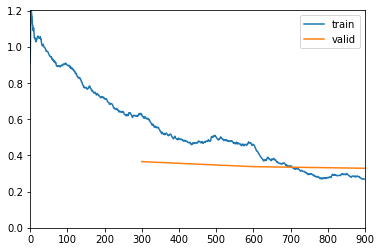

Better model found at epoch 0 with valid_loss value: 0.36558088660240173.
Better model found at epoch 1 with valid_loss value: 0.33784717321395874.
Better model found at epoch 2 with valid_loss value: 0.32895728945732117.


In [48]:
# training the model's top layer's keeping keep other layer's in freezing mode, all the metrics shown here, have been
# evaluted on validation set
learn.fit_one_cycle(3,8e-5, moms=(0.8, 0.7),wd=1e-1)

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.736844,0.708334,0.762238,0.805382,0.785658,0.651626,0.762238,0.661204,0.724600,01:28
1,0.595337,0.392328,0.827718,0.818307,0.825079,0.778883,0.827718,0.793026,0.822061,01:27


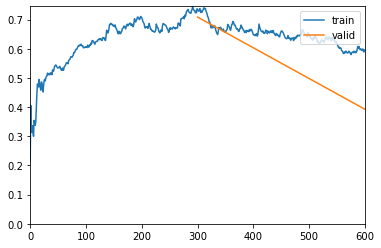

Better model found at epoch 0 with valid_loss value: 0.7083343863487244.
Better model found at epoch 1 with valid_loss value: 0.39232808351516724.


In [49]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.558243,1.601727,0.799110,0.801449,0.800071,0.725983,0.799110,0.744543,0.784999,01:30
1,0.532646,0.388410,0.831532,0.816091,0.828458,0.792583,0.831532,0.802171,0.828286,01:30
2,0.406312,0.386304,0.837254,0.817937,0.835436,0.808692,0.837254,0.812950,0.836053,01:30


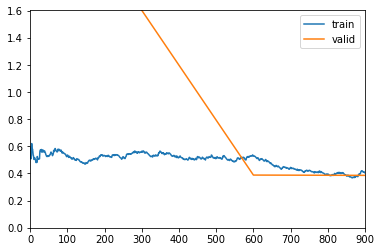

Better model found at epoch 0 with valid_loss value: 1.6017268896102905.
Better model found at epoch 1 with valid_loss value: 0.38841041922569275.
Better model found at epoch 2 with valid_loss value: 0.38630446791648865.


In [50]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(2e-3/(2.6**4), 2e-3), moms=(0.8, 0.7))

In [51]:
learn.unfreeze()
learn.lr_find()

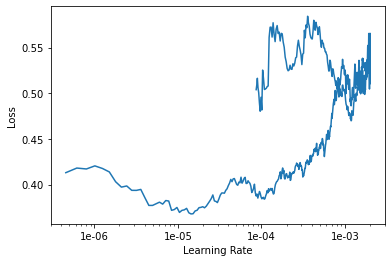

In [52]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.346041,0.393448,0.838525,0.819633,0.836633,0.809639,0.838525,0.814216,0.837243,01:32
1,0.311589,0.384408,0.835982,0.815176,0.834955,0.810707,0.835982,0.812852,0.835397,01:32


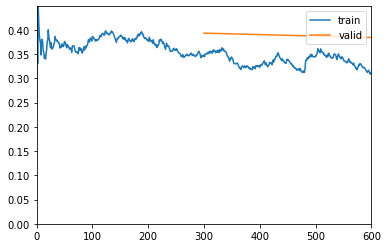

Better model found at epoch 0 with valid_loss value: 0.3934476375579834.
Better model found at epoch 1 with valid_loss value: 0.3844076693058014.


In [53]:
learn.fit_one_cycle(2, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.306382,0.449285,0.824539,0.802162,0.823285,0.797248,0.824539,0.799590,0.823820,01:32
1,0.317887,0.404030,0.832168,0.817667,0.829111,0.792070,0.832168,0.802346,0.828654,01:32
2,0.269322,0.413796,0.828353,0.815705,0.825240,0.783799,0.828353,0.795930,0.823803,01:32
3,0.255527,0.414430,0.833439,0.814313,0.831185,0.802396,0.833439,0.807751,0.831831,01:32
4,0.266667,0.432976,0.835346,0.817377,0.832874,0.802829,0.835346,0.809231,0.833417,01:32


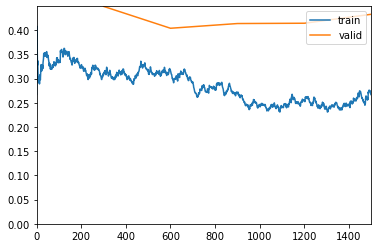

Better model found at epoch 0 with valid_loss value: 0.4492846429347992.
Better model found at epoch 1 with valid_loss value: 0.4040304720401764.
Epoch 2: reducing lr to 6.112620219362892e-05
Epoch 3: reducing lr to 1.88258346050237e-05


In [54]:
# training all layer's of the model and saving the best one 
learn.fit_one_cycle(10, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7), wd=1e-1,
                    callbacks=[SaveModelCallback(learn_img,every='improvement', monitor='accuracy', name='best')])

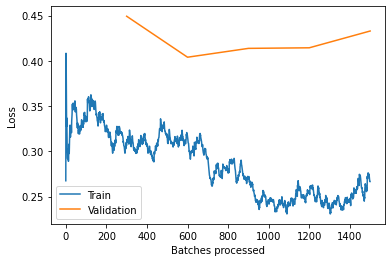

In [55]:
learn.recorder.plot_losses()

In [56]:
interp = ClassificationInterpretation.from_learner(learn)

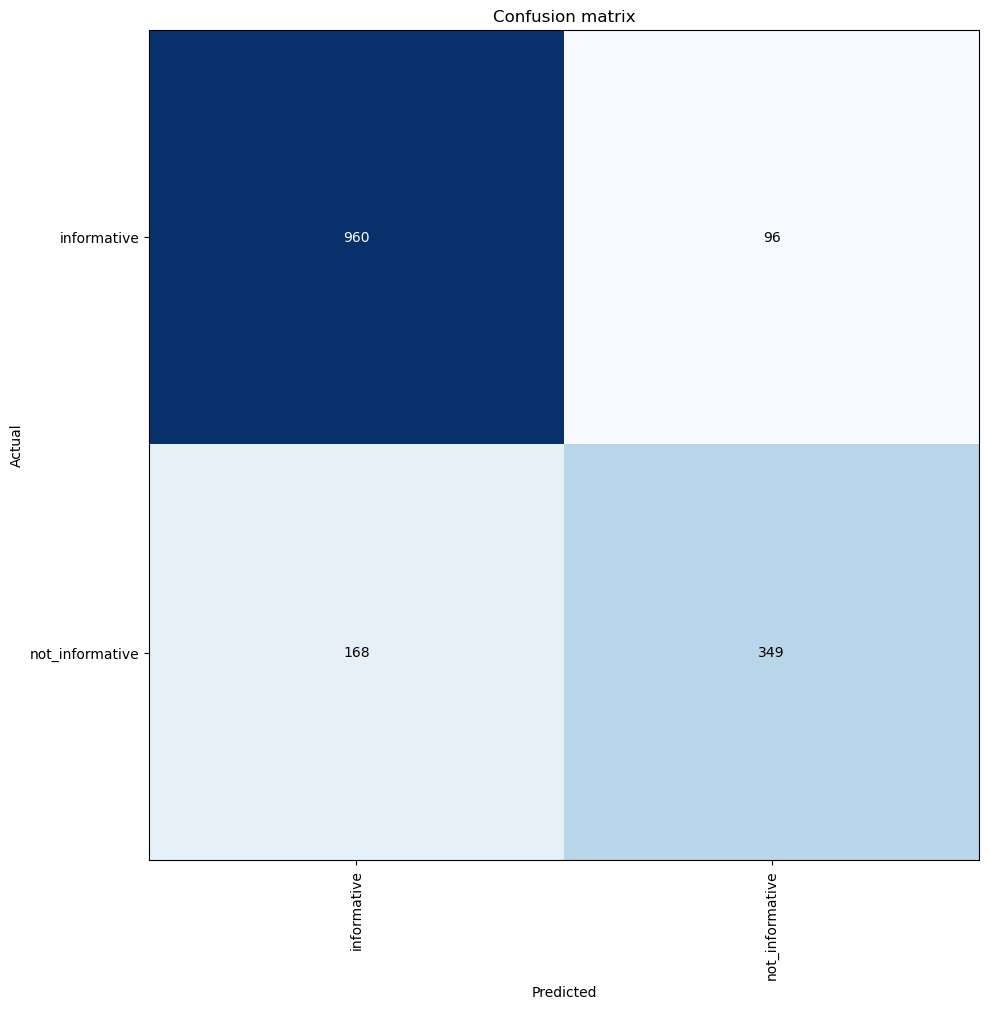

In [57]:
#plotting the confusion matrix
interp.plot_confusion_matrix(figsize=(10,10), dpi=100)

In [59]:
learn.validate(data.valid_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.40403047,
 tensor(0.8322),
 tensor(0.8177),
 tensor(0.8291),
 tensor(0.7921),
 tensor(0.8322),
 tensor(0.8023),
 tensor(0.8287)]

In [60]:
#making on validation set to use it classification report
valid_preds,valid_y,losses = learn.get_preds(ds_type=DatasetType.Valid,with_loss=True)
valid_y_preds = valid_preds.argmax(1)

target_names = ['informative','not_informative']

print(classification_report(valid_y, valid_y_preds, target_names=target_names))

                 precision    recall  f1-score   support

    informative       0.85      0.91      0.88      1056
not_informative       0.78      0.68      0.73       517

       accuracy                           0.83      1573
      macro avg       0.82      0.79      0.80      1573
   weighted avg       0.83      0.83      0.83      1573



In [61]:
learn.validate(data.valid_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.40403047,
 tensor(0.8322),
 tensor(0.8177),
 tensor(0.8291),
 tensor(0.7921),
 tensor(0.8322),
 tensor(0.8023),
 tensor(0.8287)]

In [62]:
#making on test set to use it classification report
test_preds,test_y,losses = learn.get_preds(ds_type=DatasetType.Test,with_loss=True)
test_y_preds = test_preds.argmax(1)

target_names = ['informative','not_informative']

print(classification_report(test_y, test_y_preds, target_names=target_names))

                 precision    recall  f1-score   support

    informative       0.86      0.93      0.90      1030
not_informative       0.83      0.69      0.76       504

       accuracy                           0.85      1534
      macro avg       0.85      0.81      0.83      1534
   weighted avg       0.85      0.85      0.85      1534

